# INSTALLATION!!!!!!!!!

In [ ]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow holidays tqdm
!pip install tensorflow==2.7.0

# NECESSARY IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from datetime import datetime
from tensorflow.keras.layers import LSTM, Dense
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import RepeatVector,TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError
from scipy.stats import norm
import statsmodels.api as sm
from tqdm import tqdm
import datetime
import warnings

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-16 19:58:51.360796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 19:58:51.360870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 19:58:51.362914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 19:58:51.372680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

# DATA LOADING AND PREPOCESSING

In [2]:
# Import necessary libraries
import pandas as pd

# Read the mobility data from the Apple Mobility Report CSV file
mobility_df = pd.read_csv("apple_mobility_report_US.csv")

# Read the COVID-19 cases and deaths data by county and timeseries from CSV file
covid_df = pd.read_csv("2_cases_and_deaths_by_county_timeseries.csv")

# Read the Census data for the United States from CSV file
census_data = pd.read_csv("Census_data_US.csv")

# Preprocess Census data: Remove unnecessary columns and create a 'county' column
census_data['county'] = census_data['county_and_city'].str.replace(' county', '', case=False)
census_data = census_data.drop(columns=["Unnamed: 0", "censusIncome"])

# Convert date columns to datetime format for mobility and COVID-19 data
mobility_df["date"] = pd.to_datetime(mobility_df["date"])
covid_df["date"] = pd.to_datetime(covid_df["date"])

# Create a 'county' column in mobility data by removing 'county' from 'county_and_city'
mobility_df['county'] = mobility_df['county_and_city'].str.replace(' county', '', case=False)

# Drop unnecessary columns from mobility data
mobility_df = mobility_df.drop(columns=["transit", "walking"])

# Drop the 'uid' column from COVID-19 data
covid_df = covid_df.drop(columns=["uid"])

# Drop rows with NaN values in 'location_name' and 'state' columns in COVID-19 data
covid_df = covid_df.dropna(subset=['location_name', 'state'])

# Rename the 'location_name' column to 'county' in COVID-19 data for consistency
covid_df = covid_df.rename(columns={'location_name': 'county'})

# Drop rows with NaN values in 'county', 'state' columns in mobility data
mobility_df = mobility_df.dropna(subset=['county', 'state'])

# Merge mobility data with COVID-19 data based on 'date', 'state', and 'county'
merged_df = pd.merge(mobility_df, covid_df, how='inner', on=['date', 'state', 'county'])

# Display the columns of the merged dataframe
print(merged_df.columns)


Index(['state', 'county_and_city', 'geo_type', 'date', 'driving', 'county',
       'location_type', 'fips_code', 'total_population', 'cumulative_cases',
       'cumulative_cases_per_100_000', 'cumulative_deaths',
       'cumulative_deaths_per_100_000', 'new_cases', 'new_deaths',
       'new_cases_per_100_000', 'new_deaths_per_100_000',
       'new_cases_7_day_rolling_avg', 'new_deaths_7_day_rolling_avg'],
      dtype='object')


# Data Level
## You need to specify which data level you want to get analysis for and get forecast for.
## State Level Data means it would have each day mobility and covid cases data by state level.
## State and County level means it would have each day mobility and covid cased data by each state's each county.

In [3]:
def handle_inputs():
    # Initialize variables for county and state names
    county_name = None
    state_name = None

    # Get user input for data level
    data_level = input("Select Data Level (1 for State Level Data, 2 for State and County Level): ")

    # Check data level and prompt for state and county names accordingly
    state_name = input("Enter State Name: ") if data_level == '1' or data_level == '2' else None
    county_name = input("Enter County Name: ") if data_level == '2' else None

    # Display selected data level and entered state and county names
    if data_level == '1':
        print(f"Selected Data Level: State Level Data")
        print(f"State Name: {state_name}")
    elif data_level == '2':
        print(f"Selected Data Level: State and County Level")
        print(f"State Name: {state_name}")
        print(f"County Name: {county_name}")
    else:
        print("Invalid option. Please enter 1 or 2.")

    # Return the selected data level, state name, and county name
    return data_level, state_name, county_name

# Call the function and print the results
data_level, state_name, county_name = handle_inputs()
print(data_level, state_name, county_name)


Select Data Level (1 for State Level Data, 2 for State and County Level):  2
Enter State Name:  Alabama
Enter County Name:  Autauga


Selected Data Level: State and County Level
State Name: Alabama
County Name: Autauga
2 Alabama Autauga


In [4]:
def aggregate_state_data(merged_df):
    # Define the columns to be aggregated
    columns_to_aggregate = ['state', 'date', 'driving', 'fips_code', 'total_population',
                             'cumulative_cases', 'cumulative_cases_per_100_000', 'cumulative_deaths',
                             'cumulative_deaths_per_100_000', 'new_cases', 'new_deaths',
                             'new_cases_per_100_000', 'new_deaths_per_100_000',
                             'new_cases_7_day_rolling_avg', 'new_deaths_7_day_rolling_avg']
    
    # Aggregating data at the state level
    state_level_data = merged_df.groupby(['state', 'date'])[columns_to_aggregate].agg({
        'driving': 'sum',
        'fips_code': 'first',
        'total_population': 'sum',
        'cumulative_cases': 'sum',
        'cumulative_cases_per_100_000': 'sum',
        'cumulative_deaths': 'sum',
        'cumulative_deaths_per_100_000': 'sum',
        'new_cases': 'sum',
        'new_deaths': 'sum',
        'new_cases_per_100_000': 'sum',
        'new_deaths_per_100_000': 'sum',
        'new_cases_7_day_rolling_avg': 'sum',
        'new_deaths_7_day_rolling_avg': 'sum'
    }).reset_index()

    # Drop duplicate rows
    state_level_data = state_level_data.drop_duplicates()

    # Reset the index for the resulting DataFrame
    state_level_data = state_level_data.reset_index(drop=True)

    # Return the aggregated state-level data
    return state_level_data

# Check if data_level is '1' (State Level Data)
if data_level == '1':
    merged_df = aggregate_state_data(merged_df)


In [5]:
nan_count_in_column = merged_df['state'].isnull().sum()
print(f"Number of NaN values in 'state': {nan_count_in_column}")
if county_name:
    nan_count_in_column = merged_df['county'].isnull().sum()
    print(f"Number of NaN values in 'county': {nan_count_in_column}")


Number of NaN values in 'state': 0
Number of NaN values in 'county': 0


# SanityChecker
The SanityChecker class provides essential functionality for validating and enhancing the quality of time-series data, specifically tailored for mobility and COVID-19 datasets. By enabling users to filter data based on state and county names, it conducts checks for duplicate timestamps, allowing for their identification and removal to maintain data integrity. The class further organizes the dataset by converting the date column to a datetime format and sorting entries chronologically. With an informative display of the start and end dates, the SanityChecker class empowers users to perform comprehensive sanity checks, ensuring accurate and consistent data representation over time. Its structured design and functionality make it a valuable tool for data preprocessing and verification in scenarios where reliable temporal information is crucial.

In [6]:
class SanityChecker:
    def __init__(self, merged_df):
        self.merged_df = merged_df
        self.data = None

    def get_data(self, state_name, county_name):
        if state_name and county_name:
            # Filter data for the given state and county
            self.data = self.merged_df[(self.merged_df['state'] == state_name) & (self.merged_df['county'] == county_name)]
            print("Total records for this combination: ",len(self.data))
            return self.data
        else:
            # Filter data for the given state and county
            self.data = self.merged_df[self.merged_df['state'] == state_name]
            print("Total records for this combination: ",len(self.data))
            return self.data
            

    def check_duplicate_timestamps(self, timestamp_column='date'):
        """
        Check if a DataFrame has duplicate timestamps.
    
        Parameters:
        - dataframe: Pandas DataFrame
        - timestamp_column: Name of the timestamp column (default: 'date')
    
        Returns:
        - Boolean: True if duplicates found, False otherwise
        - List of duplicate timestamps (if any)
        """
        duplicates = self.data[self.data.duplicated(subset=[timestamp_column])]
        has_duplicates = not duplicates.empty
    
        if has_duplicates:
            duplicate_timestamps = duplicates[timestamp_column].tolist()
            # print(f"Duplicate timestamps found: {duplicate_timestamps}")
        else:
            print("No duplicate timestamps found.")
    
        return has_duplicates, duplicates

    def drop_duplicate_timestamps(self, timestamp_column='date'):
        """
        Drop rows with duplicate timestamps from a DataFrame.
    
        Parameters:
        - dataframe: Pandas DataFrame
        - timestamp_column: Name of the timestamp column (default: 'date')
    
        Returns:
        - DataFrame: DataFrame without duplicate timestamps
        """
        self.data = self.data.drop_duplicates(subset=[timestamp_column])

    def do_sanity_checks(self, state_name, county_name):
        self.get_data(state_name, county_name)
        self.check_duplicate_timestamps("date")
        self.drop_duplicate_timestamps("date")
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.sort_values(by='date')
        start_date = self.data['date'].min()
        end_date = self.data['date'].max()
        
        print(f"Start Date: {start_date}")
        print(f"End Date: {end_date}")
        return self.data,start_date,end_date


SC=SanityChecker(merged_df)
SC_data,start_date,end_date=SC.do_sanity_checks(state_name,county_name)
print(SC_data.shape)
SC_data.columns

Total records for this combination:  733
No duplicate timestamps found.
Start Date: 2020-01-22 00:00:00
End Date: 2022-01-26 00:00:00
(733, 19)


Index(['state', 'county_and_city', 'geo_type', 'date', 'driving', 'county',
       'location_type', 'fips_code', 'total_population', 'cumulative_cases',
       'cumulative_cases_per_100_000', 'cumulative_deaths',
       'cumulative_deaths_per_100_000', 'new_cases', 'new_deaths',
       'new_cases_per_100_000', 'new_deaths_per_100_000',
       'new_cases_7_day_rolling_avg', 'new_deaths_7_day_rolling_avg'],
      dtype='object')

# CovidDataProcessor
The CovidDataProcessor class facilitates the exploration and visualization of key relationships between mobility data and COVID-19 statistics. This class includes several methods for plotting, allowing users to analyze the correlation between driving mobility and new cases or deaths, observe the trend of mobility and new cases over time, and compare mobility with cumulative cases and deaths. The analysis_plot method serves as a consolidated function, generating multiple plots for comprehensive analysis, such as a line plot of mobility vs. new cases, a correlation scatter plot, and various bar plots. The user can specify a date range for focused analysis. In the provided example, the CovidDataProcessor class is instantiated with a subset of data (SC_data), and the analysis_plot method is called with a specified date range ('2020-02-06' to '2020-03-06') to demonstrate its functionality. This class enhances the interpretability of the dataset, aiding in understanding the dynamics between mobility trends and COVID-19 statistics during specific time periods.

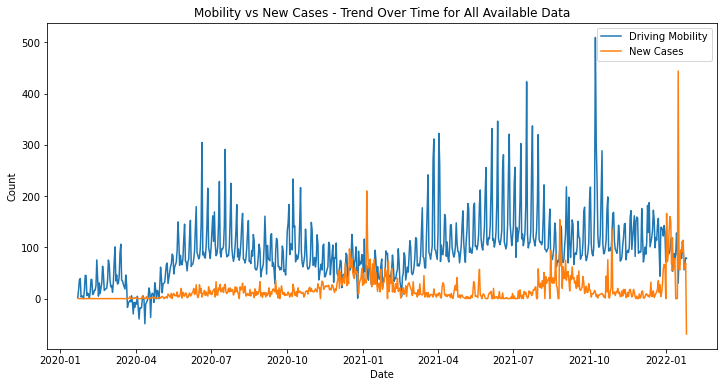

In [7]:
class CovidDataProcessor:
    def __init__(self,data):
        self.data=data

    def plot_correlation_driving_cases_deaths(self, st_date=None, end_date=None):
        """
        Plot the correlation between 'driving' mobility and 'new_cases', 'new_deaths'.
        
        Parameters:
        - st_date (str): Start date for filtering data (optional).
        - end_date (str): End date for filtering data (optional).
        
        Interpretation:
        - Two subplots show scatterplots for 'driving' vs 'new_cases' and 'new_deaths'.
        - Helps visualize the correlation between mobility and new cases/deaths.
        """
        if st_date is not None and end_date is not None:
            filtered_data = self.data[(pd.to_datetime(self.data['date']) >= st_date) & (pd.to_datetime(self.data['date']) <= end_date)]
        elif st_date is not None:
            filtered_data = self.data[pd.to_datetime(self.data['date']) >= st_date]
        elif end_date is not None:
            filtered_data = self.data[pd.to_datetime(self.data['date']) <= end_date]
        else:
            filtered_data = self.data
        
        plt.figure(figsize=(15, 8))
    
        # Plotting correlation between 'driving' and 'new_cases'
        plt.subplot(1, 2, 1)
        plt.scatter(filtered_data['driving'], filtered_data['new_cases'], alpha=0.5)
        plt.title('Correlation: Driving vs New Cases')
        plt.xlabel('Driving Mobility')
        plt.ylabel('New Cases')
    
        # Plotting correlation between 'driving' and 'new_deaths'
        plt.subplot(1, 2, 2)
        plt.scatter(filtered_data['driving'], filtered_data['new_deaths'], alpha=0.5)
        plt.title('Correlation: Driving vs New Deaths')
        plt.xlabel('Driving Mobility')
        plt.ylabel('New Deaths')
    
        plt.tight_layout()
        plt.show()

    def plot_mobility_vs_new_cases_line_all_data(self):
        """
        Plot the trend of 'driving' mobility and 'new_cases' over time using a line plot.
               
        Interpretation:
        - Line plot shows the trend of 'driving' mobility and 'new_cases' over time.
        - Useful for understanding the temporal relationship between mobility and cases.
        """

        filtered_data = self.data
        
        plt.figure(figsize=(12, 6))
        plt.plot(np.array(filtered_data['date']), np.array(filtered_data['driving']), label='Driving Mobility')
        plt.plot(np.array(filtered_data['date']), np.array(filtered_data['new_cases']), label='New Cases')
        plt.title('Mobility vs New Cases - Trend Over Time for All Available Data')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.legend()
        plt.show()

    def plot_mobility_vs_new_cases_line(self, st_date=None, end_date=None):
        """
        Plot the trend of 'driving' mobility and 'new_cases' over time using a line plot.
        
        Parameters:
        - st_date (str): Start date for filtering data (optional).
        - end_date (str): End date for filtering data (optional).
        
        Interpretation:
        - Line plot shows the trend of 'driving' mobility and 'new_cases' over time.
        - Useful for understanding the temporal relationship between mobility and cases.
        """

        if st_date is not None and end_date is not None:
            filtered_data = self.data[(pd.to_datetime(self.data['date']) >= st_date) & (pd.to_datetime(self.data['date']) <= end_date)]
        elif st_date is not None:
            filtered_data = self.data[pd.to_datetime(self.data['date']) >= st_date]
        elif end_date is not None:
            filtered_data = self.data[pd.to_datetime(self.data['date']) <= end_date]
        else:
            filtered_data = self.data
        
        plt.figure(figsize=(12, 6))
        plt.plot(np.array(filtered_data['date']), np.array(filtered_data['driving']), label='Driving Mobility')
        plt.plot(np.array(filtered_data['date']), np.array(filtered_data['new_cases']), label='New Cases')
        plt.title('Mobility vs New Cases - Trend Over Time')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.legend()
        plt.show()

    def bar_plot_mobility_new_cases_deaths(self,st_date=None,end_date=None):
        """
        Plot a bar chart for 'driving' mobility, 'new_cases', and 'new_deaths' over time.
        
        Parameters:
        - st_date (str): Start date for filtering data (optional).
        - end_date (str): End date for filtering data (optional).
        
        Interpretation:
        - Bar chart visualizes the count of 'driving', 'new_cases', and 'new_deaths'.
        - Useful for comparing mobility with new cases and deaths.
        """

        if st_date is not None and end_date is not None:
            filtered_data = self.data[(self.data['date'] >= st_date) & (self.data['date'] <= end_date)]
        elif st_date is not None:
            filtered_data = self.data[self.data['date'] >= st_date]
        elif end_date is not None:
            filtered_data = self.data[self.data['date'] <= end_date]
        else:
            filtered_data = self.data
        plt.figure(figsize=(12, 6))
        filtered_data[['date', 'driving', 'new_deaths', 'new_cases']].set_index('date').plot(kind='bar')
        plt.title('Bar Plot: Mobility, New Cases, New Deaths')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.show()

    def bar_plot_mobility_cumulative_cases_deaths(self, st_date=None, end_date=None):
        """
        Plot a bar chart for 'driving' mobility, 'cumulative_cases', and 'cumulative_deaths' over time.
        
        Parameters:
        - st_date (str): Start date for filtering data (optional).
        - end_date (str): End date for filtering data (optional).
        
        Interpretation:
        - Bar chart visualizes the count of 'driving', 'cumulative_cases', and 'cumulative_deaths'.
        - Useful for comparing mobility with cumulative cases and deaths.
        """

        if st_date is not None and end_date is not None:
            filtered_data = self.data[(pd.to_datetime(self.data['date']) >= st_date) & (pd.to_datetime(self.data['date']) <= end_date)]
        elif st_date is not None:
            filtered_data = self.data[pd.to_datetime(self.data['date']) >= st_date]
        elif end_date is not None:
            filtered_data = self.data[pd.to_datetime(self.data['date']) <= end_date]
        else:
            filtered_data = self.data
        
        plt.figure(figsize=(12, 6))
        filtered_data[['date', 'driving', 'cumulative_cases', 'cumulative_deaths']].set_index('date').plot(kind='bar')
        plt.title('Bar Plot: Mobility, Cumulative Cases, Cumulative Deaths')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.show()

    def analysis_plot(self,st_date,end_date):
        self.plot_mobility_vs_new_cases_line_all_data()
        self.plot_correlation_driving_cases_deaths(st_date,end_date)
        self.plot_mobility_vs_new_cases_line(st_date,end_date)
        self.bar_plot_mobility_new_cases_deaths(st_date,end_date)
        self.bar_plot_mobility_cumulative_cases_deaths(st_date,end_date)
        
analyzer = CovidDataProcessor(SC_data)
analyzer.plot_mobility_vs_new_cases_line_all_data()

# analyzer.analysis_plot('2020-02-06','2020-03-06')

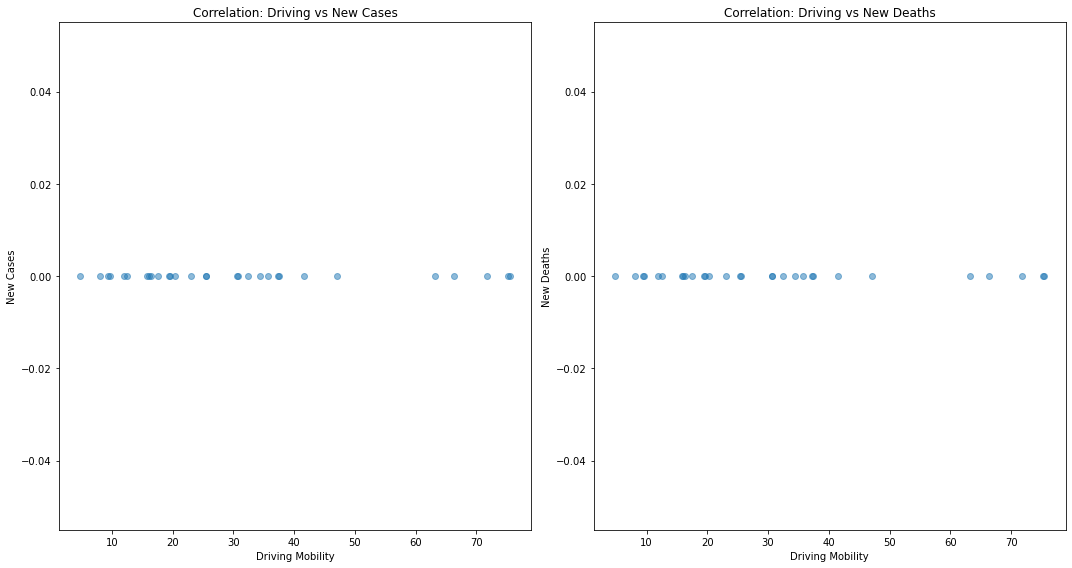

In [8]:
analyzer.plot_correlation_driving_cases_deaths('2020-02-06','2020-03-06')


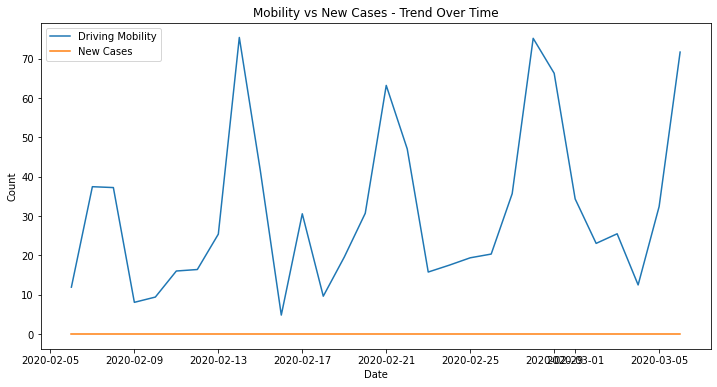

In [9]:
analyzer.plot_mobility_vs_new_cases_line('2020-02-06','2020-03-06')


<Figure size 864x432 with 0 Axes>

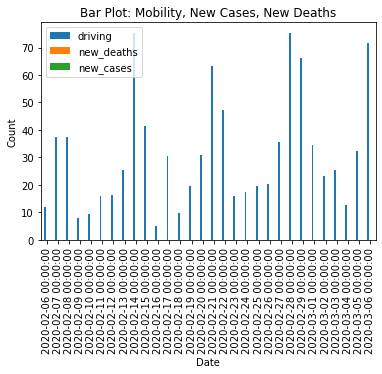

In [10]:
analyzer.bar_plot_mobility_new_cases_deaths('2020-02-06','2020-03-06')


<Figure size 864x432 with 0 Axes>

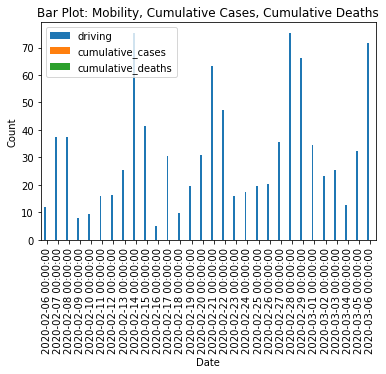

In [11]:
analyzer.bar_plot_mobility_cumulative_cases_deaths('2020-02-06','2020-03-06')

# FeaturePreEngVisSel
The FeaturePreEngVisSel class combines essential functionalities for preprocessing, engineering, visualization, and selection of features in a given dataset. The class is designed to enhance the dataset's quality, extract meaningful information, and aid in selecting relevant features for downstream analysis or modeling. Key methods within the class include:

    feature_preprocessing: Forward fills and backward fills missing values in the dataset, ensuring completeness.

    add_day_of_week, add_weekend, add_holiday, add_month_and_year, add_season, add_days_since_start, add_rolling_statistics, add_day_n_statistics: These methods add various time-related features, such as day of the week, weekend indicator, holiday indicator, month, season, days since the start, rolling statistics, etc.

    categorical_encoding: Identifies and one-hot encodes categorical columns in the dataset.

    feature_engineering: Combines all the above feature-related methods to perform comprehensive feature engineering on the dataset.

    plot_cases_vs_feature, plot_deaths_vs_feature, plot_correlation_heatmap: These methods generate visualizations to help analyze the relationship between cases or deaths and engineered features.

    feature_selection: Performs feature selection using mutual information regression and correlation-based methods. It also includes a feature importance plot.

    do_feature_preprocessing_engineering_visulization_selection: Integrates all the above methods to perform the entire feature processing pipeline.

(733, 19)


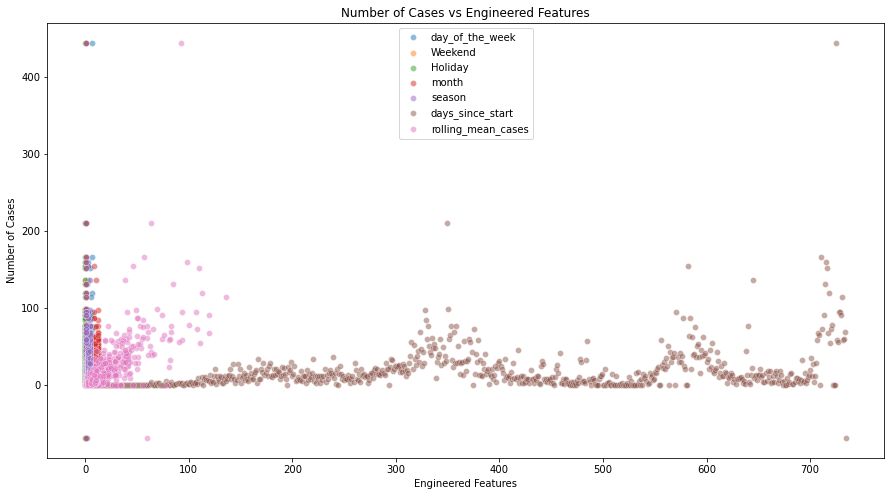

In [12]:
class FeaturePreEngVisSel: #FeaturePreprocessorEngineeringVisualizationSelection
    def __init__(self, data):
        self.data=data

    def feature_preprocessing(self):
        """
        Perform feature preprocessing by forward filling and backward filling missing values in the dataset.
        
        Parameters:
        - No explicit parameters.
        
        Interpretation:
        - Fills missing values in the dataset using forward fill and backward fill methods.
        - Helps ensure completeness of the dataset.
        """

        # Forward fill missing values
        self.data = self.data.ffill()

        # Backward fill missing values
        self.data = self.data.bfill()
        return self.data

    def add_day_of_week(self):
        """
        Add a column for the day of the week (0 for Monday, 6 for Sunday).
        
        Parameters:
        - No explicit parameters.
        """

        self.data['day_of_the_week'] = pd.to_datetime(self.data['date']).dt.dayofweek

    def add_weekend(self):
        """
        Add a column indicating whether it's a weekend.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['Weekend'] = pd.to_datetime(self.data['date']).dt.dayofweek.isin([5, 6])

    def add_holiday(self):
        """
        Add a column indicating whether it's a holiday using the holidays library for the United States.
        
        Parameters:
        - No explicit parameters.
        """

        us_holidays = holidays.UnitedStates(years=range(2020, 2023))  # You can adjust the range as needed

        # Add a boolean column indicating whether it's a holiday
        self.data['Holiday'] = pd.to_datetime(self.data['date']).dt.date.apply(lambda x: x in us_holidays)

    def add_month_and_year(self):
        """
        Add columns for the month and year extracted from the date.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['month'] = pd.to_datetime(self.data['date']).dt.month
        self.data['year'] = pd.to_datetime(self.data['date']).dt.year

    def add_season(self):
        """
        Add a column for the quarter of the year.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['season'] = pd.to_datetime(self.data['date']).dt.quarter
        

    def add_day_month_combination(self):
        """
        Add a column for the combination of day and month.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['day_month_comb'] = pd.to_datetime(self.data['date']).dt.strftime('%d%m')

    def add_days_since_start(self):
        """
        Add a column for the number of days since the start of the dataset/covid.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['days_since_start'] = (pd.to_datetime(self.data['date']) - self.data['date'].min()).dt.days

    def add_rolling_statistics(self):
        """
        Add a column for the 7-day rolling mean of 'new_cases'.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['rolling_mean_cases'] = self.data['new_cases'].rolling(window=7).mean()

    def add_day_n_statistics(self):
        """
        Add a column for the mean of 'new_cases' from the previous week.
        
        Parameters:
        - No explicit parameters.
        """

        self.data['mean_cases_last_week'] = self.data['new_cases'].shift(1).rolling(window=7).mean()

    def categorical_encoding(self):
        """
        Identify and one-hot encode categorical columns.
        
        Parameters:
        - No explicit parameters.
        """

        # Identify categorical columns (assuming you want to one-hot encode all non-numeric columns)
        categorical_columns = self.data.select_dtypes(include=['object']).columns

        # One-hot encode categorical columns
        self.data = pd.get_dummies(self.data, columns=categorical_columns)

    def feature_engineering(self):
        """
        Identify and one-hot encode categorical columns.
        
        Parameters:
        - No explicit parameters.
        """

        self.add_day_of_week()
        self.add_weekend()
        self.add_holiday()
        self.add_month_and_year()
        self.add_season()
        # self.add_day_month_combination()
        self.add_days_since_start()
        self.add_rolling_statistics()
        self.add_day_n_statistics()
        # self.categorical_encoding()
        return self.data
    

    def plot_cases_vs_feature(self):
        """
        Plot a scatterplot for the number of cases vs. engineered features.
    
        Parameters:
        - No explicit parameters, uses the 'selected_features' and 'new_cases' columns from the class's data.
    
        Interpretation:
        - Each point represents a data entry.
        - Scatterplots show the relationship between the number of cases and each engineered feature.
        - Transparency (alpha=0.5) helps visualize overlapping points.
    
        Example Usage:
        >>> data_processor.plot_cases_vs_feature()
        """
        selected_features = ['day_of_the_week', 'Weekend', 'Holiday', 'month', 'season', 'days_since_start', 'rolling_mean_cases']
        plt.figure(figsize=(15, 8))
        for feature in selected_features:
            sns.scatterplot(x=feature, y='new_cases', data=self.data, alpha=0.5, label=feature)
        plt.title('Number of Cases vs Engineered Features')
        plt.xlabel('Engineered Features')
        plt.ylabel('Number of Cases')
        plt.legend()
        plt.show()


    def plot_deaths_vs_feature(self):
        """
        Plot a scatterplot for the number of deaths vs. engineered features.

        Parameters:
        - No explicit parameters, uses the 'selected_features' and 'new_deaths' columns from the class's data.

        Interpretation:
        - Each point represents a data entry.
        - Scatterplots show the relationship between the number of deaths and each engineered feature.
        - Transparency (alpha=0.5) helps visualize overlapping points.

        Example Usage:
        >>> data_processor.plot_deaths_vs_feature()
        """
        selected_features = ['day_of_the_week', 'Weekend', 'Holiday', 'month', 'season', 'days_since_start', 'rolling_mean_cases']
        plt.figure(figsize=(15, 8))
        for feature in selected_features:
            sns.scatterplot(x=feature, y='new_deaths', data=self.data, alpha=0.5, label=feature)
        plt.title('Number of Deaths vs Engineered Features')
        plt.xlabel('Engineered Features')
        plt.ylabel('Number of Deaths')
        plt.legend()
        plt.show()

    def plot_correlation_heatmap(self):
        """
        Plot a correlation heatmap for selected features, including cases and deaths.

        Parameters:
        - No explicit parameters, uses the 'selected_features', 'new_cases', and 'new_deaths' columns from the class's data.

        Interpretation:
        - Heatmap shows the correlation between selected features, new cases, and new deaths.
        - Values closer to 1 or -1 indicate stronger positive or negative correlations.
        - Useful for identifying relationships between variables.

        Example Usage:
        >>> data_processor.plot_correlation_heatmap()
        """
        selected_features = ['day_of_the_week', 'Weekend', 'Holiday', 'month', 'season', 'days_since_start', 'rolling_mean_cases', 'new_cases', 'new_deaths']
        correlation_matrix = self.data[selected_features].corr()
        plt.figure(figsize=(15, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
        plt.title('Correlation Heatmap')
        plt.show()

    def feature_selection(self):
        """
        Perform feature selection using mutual information regression and correlation-based methods,
        and plot feature importance.

        Parameters:
        - No explicit parameters, uses all columns from the class's data.

        Interpretation:
        - Feature importance plot shows the relevance of each feature for predicting new cases.
        - Higher values indicate more important features.
        - Useful for selecting features for modeling.

        Example Usage:
        >>> data_processor.feature_selection()
        """
        # Convert categorical columns to numerical using Label Encoding
        dates=self.data["date"]
        self.data=self.data.drop(columns=["date"])
        print(self.data.shape)
        categorical_columns = self.data.select_dtypes(include=['object']).columns
        print(categorical_columns)
        label_encoder = LabelEncoder()
        for column in categorical_columns:
            self.data[column] = label_encoder.fit_transform(self.data[column])

        column_list = self.data.columns
        for k, column in enumerate(column_list):
                self.data[column]=   self.data[column].fillna(method='ffill').fillna(method='bfill')

        # # Impute missing values in features
        # imputer = SimpleImputer(strategy='mean')
        # X_imputed = pd.DataFrame(imputer.fit_transform(data), columns=self.data.columns)


        # Extract target variable
        y = self.data['new_cases']

        # Perform mutual information regression
        feature_importance_mi = mutual_info_regression(self.data, y)
        feature_importance_mi = pd.Series(feature_importance_mi, index=self.data.columns)

        # Plot mutual information feature importance
        feature_importance_mi.plot.bar()
        plt.title('Mutual Information Feature Importance')
        plt.show()

        # Perform correlation-based feature selection
        correlation_matrix = self.data.corr()
        selected_features_corr = set(correlation_matrix.loc[correlation_matrix['new_cases'].abs() > 0.1].index)
        plt.figure(figsize=(15, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
        plt.title('Correlation Heatmap')
        plt.show()

        # Select features based on intersection of mutual information and correlation-based selection
        selected_features = set(feature_importance_mi[feature_importance_mi > 0].index) & selected_features_corr

        # Print selected features
        print("Selected Features:", selected_features)
        selected_features=list(selected_features)
        # selected_features.append("new_cases")
        self.data = self.data[selected_features]
        self.data["date"]=dates
        return self.data


    def do_feature_preprocessing_engineering_visulization_selection(self):
        dates=self.data["date"]
        self.data=self.feature_preprocessing()
        self.data=self.feature_engineering()
        self.plot_cases_vs_feature()
        self.plot_deaths_vs_feature()
        self.plot_correlation_heatmap()
        print(self.data.shape)
        self.data=self.feature_selection()
        self.data["date"]=dates
        return self.data
print(SC_data.shape)
feature_processor = FeaturePreEngVisSel(SC_data)
PreProcessed_data=feature_processor.feature_preprocessing()
engineered_data=feature_processor.feature_engineering()
feature_processor.plot_cases_vs_feature()

# PreProcessed_data=feature_processor.do_feature_preprocessing_engineering_visulization_selection()
# print(PreProcessed_data.shape)

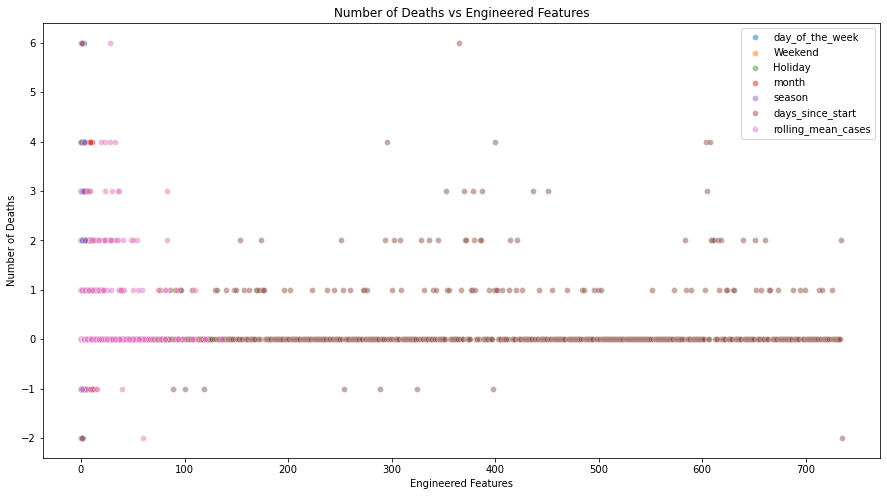

In [13]:
feature_processor.plot_deaths_vs_feature()


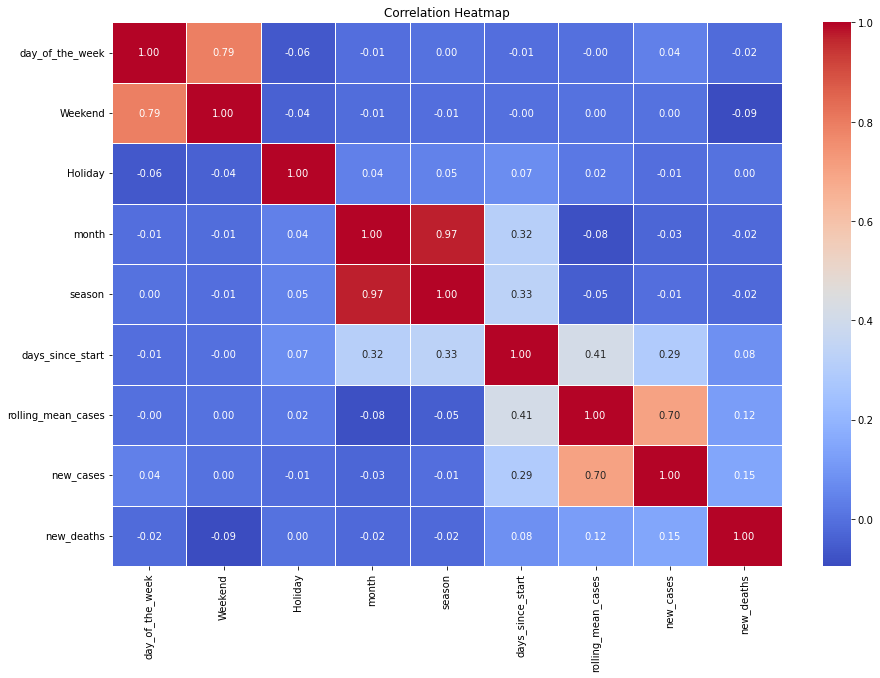

In [14]:
feature_processor.plot_correlation_heatmap()


(733, 27)
Index(['state', 'county_and_city', 'geo_type', 'county', 'location_type'], dtype='object')


/tmp/ipykernel_38324/3209506423.py:255: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data[column]=   self.data[column].fillna(method='ffill').fillna(method='bfill')


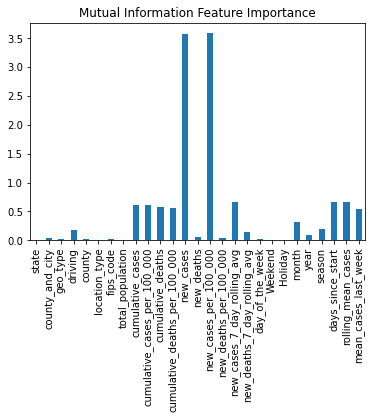

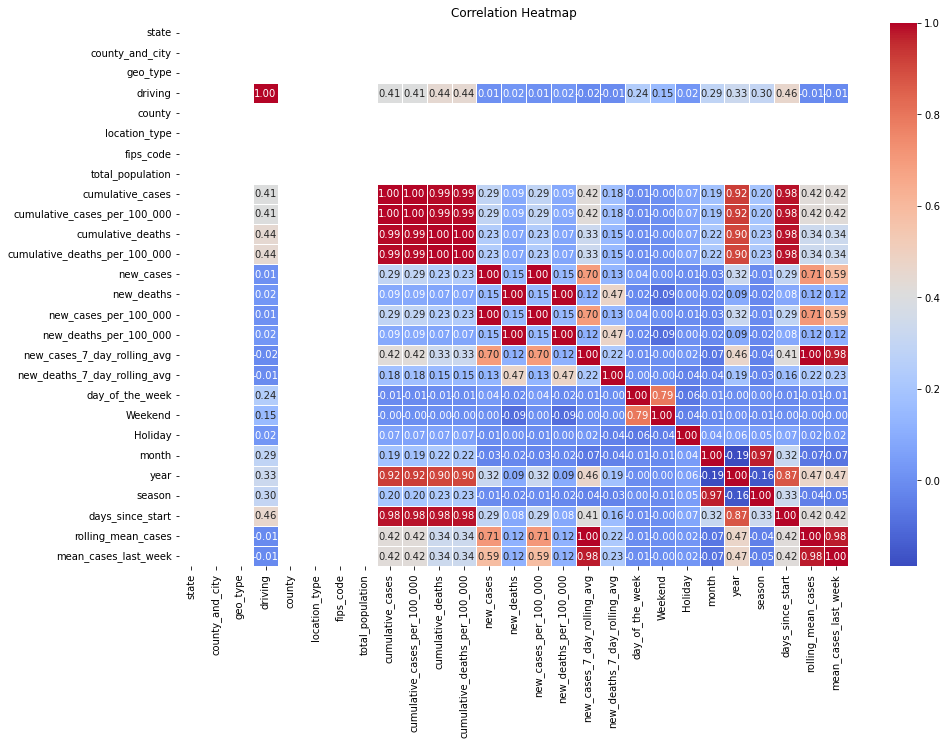

Selected Features: {'cumulative_cases', 'cumulative_cases_per_100_000', 'cumulative_deaths', 'new_deaths', 'new_cases', 'new_deaths_per_100_000', 'new_cases_7_day_rolling_avg', 'cumulative_deaths_per_100_000', 'rolling_mean_cases', 'mean_cases_last_week', 'new_deaths_7_day_rolling_avg', 'new_cases_per_100_000', 'year', 'days_since_start'}


Index(['cumulative_cases', 'cumulative_cases_per_100_000', 'cumulative_deaths',
       'new_deaths', 'new_cases', 'new_deaths_per_100_000',
       'new_cases_7_day_rolling_avg', 'cumulative_deaths_per_100_000',
       'rolling_mean_cases', 'mean_cases_last_week',
       'new_deaths_7_day_rolling_avg', 'new_cases_per_100_000', 'year',
       'days_since_start', 'date'],
      dtype='object')

In [15]:
feature_selected_data=feature_processor.feature_selection()
feature_selected_data.columns

# CovidForecastAnalyzer
The CovidForecastAnalyzer class is designed for time series forecasting of new COVID-19 cases. It provides functionality for forecasting the next 7 days using two different models: Long Short-Term Memory (LSTM) and Seasonal Autoregressive Integrated Moving Average with Exogenous Factors (SARIMAX).

Here's a breakdown of the key functionalities:

    to_supervised: This method converts time series data into supervised learning format, which is necessary for training machine learning models. It takes the historical data and the number of input and output steps as parameters.

    forecast_next_7_days: This method preprocesses the data, creates a time series of new cases and differences (indicating positive, negative, or neutral trends), and then applies either the LSTM or SARIMAX model to forecast the next 7 days. The results, including actuals, forecasts, MAPE, and trend classifications, are printed and stored in a dictionary.

    LSTM_Model: This method implements the LSTM model for time series forecasting. It trains the model on historical data and then makes predictions for the next 7 days. The results, along with trend classifications, are stored and printed.

    SARIMAX_Model: This method implements the SARIMAX model for time series forecasting. It fits the model using historical data and exogenous factors and then forecasts the next 7 days. The results, including trend classifications, are stored and printed.

    The results from both models are stored in a dictionary (dict_df), which is then saved to an Excel file.

    The forecast_next_7_days method is called with an instance of the class (forecast_analyzer) using the provided feature_selected_data.

726
7
        Date  Actuals      Forecast
0 2022-01-21     91.0 -2.567633e-09
0 2022-01-22    114.0  3.083974e-09
0 2022-01-23     58.0  4.440000e+02
0 2022-01-24     60.0  5.800000e+01
0 2022-01-25     69.0  5.600000e+01


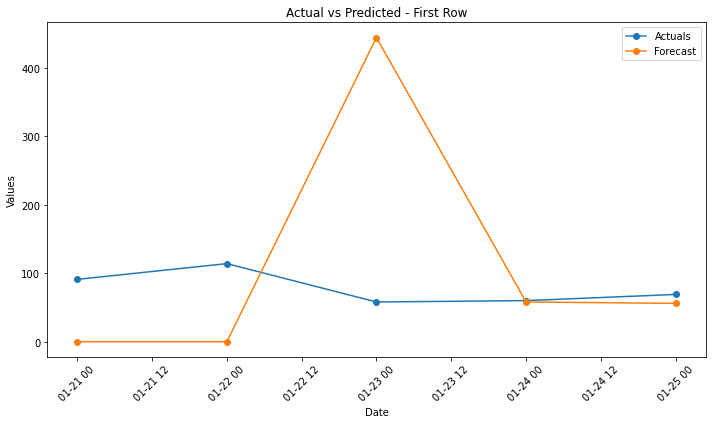

In [16]:
from numpy import array
class CovidForecastAnalyzer:
    def __init__(self, data):
        self.data = data

    # convert history into inputs and outputs
    def to_supervised(self,train, n_input, n_out=7):
    # 	print(train.shape)
    	# flatten data
    	data =train# train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    	X, y = list(), list()
    	in_start = 0
    	# step over the entire history one time step at a time
    	for _ in range(len(data)):
    		# define the end of the input sequence
    		in_end = in_start + n_input
    		out_end = in_end + n_out
    		# ensure we have enough data for this instance
    		if out_end <= len(data):
    			X.append(data[in_start:in_end, :])
    			y.append(data[in_end:out_end, 0])
    		# move along one time step
    		in_start += 1
    	return array(X), array(y)

    def plot_actual_vs_predicted(self, results_dict):
        """
        Plot actual vs predicted values for each DataFrame in the given dictionary.
    
        Parameters:
        - results_dict (dict): A dictionary where keys are dates, and values are DataFrames with 'Date', 'Actuals', 'Forecast' columns.
    
        Returns:
        - None: Plots are displayed.
        """
        for date, df in results_dict.items():
            plt.figure(figsize=(10, 6))
            plt.plot(df['Date'], df['Actuals'], label='Actuals', marker='o')
            plt.plot(df['Date'], df['Forecast'], label='Forecast', marker='o')
            plt.title(f'Actual vs Predicted - {date}')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

    
    def plot_first_row_actual_vs_predicted(self,results_dict):
        """
        Plot actual vs predicted values using the first row from each DataFrame in the given dictionary.
    
        Parameters:
        - results_dict (dict): A dictionary where keys are dates, and values are DataFrames with 'Date', 'Actuals', 'Forecast' columns.
    
        Returns:
        - None: Plots are displayed.
        """
        # Extract the first row from each DataFrame
        first_rows = [(df.iloc[0]) for date, df in results_dict.items()]
        # print(first_rows)
    
        # Create a new DataFrame from the first rows
        combined_df = pd.DataFrame(first_rows, columns=['Date', 'Actuals', 'Forecast'])
        print(combined_df)
    
        # Convert DataFrame to NumPy array before indexing
        date_values = combined_df['Date'].values
        actual_values = combined_df['Actuals'].values
        forecast_values = combined_df['Forecast'].values
    
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.plot(date_values, actual_values, label='Actuals', marker='o')
        plt.plot(date_values, forecast_values, label='Forecast', marker='o')
        plt.title('Actual vs Predicted - First Row')
        plt.xlabel('Date')
        plt.ylabel('Values')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


    def forecast_next_7_days(self):
        warnings.filterwarnings("ignore")
        # self.data = self.data.drop(columns=["date"])
        # self.data.index = self.data.date
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.sort_index()
        vals=self.data.date.values
        self.data=self.data.drop(columns=["date"],axis=1)
        self.data.insert(0, 'date', vals)
        vals=self.data.new_cases.values
        self.data=self.data.drop(columns=["new_cases"],axis=1)
        self.data.insert(1, 'new_cases', vals)
        self.data['td'] = 0
        column_list = self.data.columns
        for i, column in enumerate(column_list):
            self.data[column]=   self.data[column].fillna(method='ffill').fillna(method='bfill')
        tdvals=[0]
        for i in range(1, self.data.shape[0]):
            r=self.data.new_cases[i] - self.data.new_cases[i-1]
            tdvals.append(r)
        
        self.data=self.data.drop(columns=["td"],axis=1)
        self.data.insert(len(self.data.columns), 'td', tdvals)
        self.data.td[self.data.td <0] = -1
        # DF.td[DF.td ==0] = 0
        self.data.td[self.data.td >=0] = 1

        cols=self.data.columns

        df1 = self.data[self.data.date >= '2022-01-20']
        df=self.data[self.data.date < '2022-01-20']
        dict_df=dict()

        
        df1=np.array(df1)
        df=np.array(df)
        list1=[X for X in df]
        list2=[X for X in df1]
        print(len(list1))
        print(len(list2))
        #lstm_results= self.LSTM_Model(list1,list2,df,df1,cols)
        # self.plot_first_row_actual_vs_predicted(lstm_results)
        sarimax_results=self.SARIMAX_Model(list1,list2,df,df1,cols)
        self.plot_first_row_actual_vs_predicted(sarimax_results)
        

    def LSTM_Model(self, list1,list2,df,df1,cols):
        dict_df=dict()
        last_forecast=100000

        for i in range(len(df1)):
            list1.append(list2[i])
            df = pd.DataFrame (list1, columns = cols)
            df['new_cases']=df['new_cases']+1000
            train_dates = pd.to_datetime(df['date'])
            colss = list(df)[1:]
            df_for_training = df[colss].astype(float)
            column_list = df_for_training.columns
            for k, column in enumerate(column_list):
                df_for_training[column]=   df_for_training[column].fillna(method='ffill').fillna(method='bfill')
            scaler = StandardScaler(with_mean=False)
            df_for_training_scaled = scaler.fit_transform(df_for_training)
            X,Y=self.to_supervised(df_for_training_scaled,5,7)
            X_train1, y_train1 = X,Y
            print(train_dates.values[-1])
            verbose, epochs, batch_size = 1, 300, 16
            n_timesteps, n_features, n_outputs = X_train1.shape[1], X_train1.shape[2], y_train1.shape[1]
            model1 = Sequential()
            model1.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
            model1.add(RepeatVector(n_outputs))
            model1.add(LSTM(200, activation='relu', return_sequences=True))
            model1.add(TimeDistributed(Dense(100, activation='relu')))
            model1.add(TimeDistributed(Dense(1)))
            model1.compile(loss='mape', optimizer='adam',metrics=[RootMeanSquaredError()])
            model1.fit(X_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=verbose)
            history = [x for x in df_for_training_scaled]
            history=np.array(history)
            input_x = history[-5:, :]
            input_x=input_x.reshape(1,input_x.shape[0],input_x.shape[1])
            test_prediction = model1.predict(input_x).flatten()
            test_prediction = test_prediction.reshape(test_prediction.shape[0], 1)
            prediction_copies = np.repeat(test_prediction,df_for_training.shape[1], axis=-1)
            y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
            y_pred_future=y_pred_future-1000
            print("###########################################################################################")
            print(train_dates.values[-1])
            print(y_pred_future)
            Actuals=list2[i+1:i+8]
            act=[]
            for j in range(len(Actuals)):
                act.append(Actuals[j][1])
            dat=[]
            for j in range(len(Actuals)):
                dat.append(Actuals[j][0])
            tr=[]
            for j in range(len(Actuals)):
                tr.append(Actuals[j][-1])
            pred_df=pd.DataFrame()
            pred_df['Date']=dat
            pred_df['Actuals']=act
            pred_df['Forecast']=y_pred_future
            pred_df['MAPE'] = abs(pred_df['Actuals']-pred_df['Forecast'])*100/pred_df['Actuals']
            pred_df['d']=tr
            
            pred_df['dhat'] = 0
            pred_df['dhat'][0] = float(pred_df.Forecast[0]) - float(last_forecast)
            last_forecast = pred_df['Forecast'][0]
            for i in range(1, pred_df.shape[0]):
                pred_df.dhat[i] = pred_df.Forecast[i] - pred_df.Forecast[i-1]    
            pred_df.dhat[pred_df.dhat <0] = -1
            pred_df.dhat[pred_df.dhat >0] = 1
            pred_df.dhat.replace({0: 'neutral', 1:'positive', -1:'negative'}, inplace=True)
            pred_df.d.replace({0: 'neutral', 1:'positive', -1:'negative'}, inplace=True)
            pred_df['d']=tr
    
            pred_df['dhat'] = 0
            pred_df['dhat'][0] = float(pred_df.Forecast[0]) - float(last_forecast)
            last_forecast = pred_df['Forecast'][0]
            for i in range(1, pred_df.shape[0]):
                pred_df.dhat[i] = pred_df.Forecast[i] - pred_df.Forecast[i-1]    
            pred_df.dhat[pred_df.dhat <0] = -1
            pred_df.dhat[pred_df.dhat >0] = 1
            pred_df.dhat.replace({0: 'neutral', 1:'positive', -1:'negative'}, inplace=True)
            pred_df.d.replace({0: 'neutral', 1:'positive', -1:'negative'}, inplace=True)
            print(pred_df)
            dict_df[str(train_dates.values[-1])[:10]]=pred_df
        #     print(dict_df)
            save_xls(dict_df, "LSTMResults.xlsx")
            print("###########################################################################################")
        return dict_df

    def SARIMAX_Model(self,list1,list2,df,df1,cols):
        dict_df=dict()
        last_forecast=100000
    
        for i in range(len(df1)):
            list1.append(list2[i])
            df = pd.DataFrame (list1, columns = cols)
            train_dates = pd.to_datetime(df['date'])
            colss = list(df)[1:]
            df_for_training = df[colss].astype(float)
            column_list = df_for_training.columns
            for k, column in enumerate(column_list):
                df_for_training[column]=   df_for_training[column].fillna(method='ffill').fillna(method='bfill')
            exog_data = df_for_training#.drop(['close_price'],axis=1)
            exog = exog_data
            endog = df_for_training[u'new_cases']
            # print(train_dates.values[-1])
            mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1),seasonal_order=(1,0,1,12))
            fit_res = mod.fit(disp=False)
            
            input_x=df_for_training[-7:]
            pred=fit_res.forecast(steps = len(input_x),exog=input_x,dynamic=True,
                                      typ = 'levels')
            Actuals=list2[i+1:]
            if len(Actuals)>1:
                act=[]
                for j in range(len(Actuals)):
                    act.append(Actuals[j][1])
                dat=[]
                for j in range(len(Actuals)):
                    dat.append(Actuals[j][0])
                tr=[]
                for j in range(len(Actuals)):
                    tr.append(Actuals[j][-1])
                pred_df=pd.DataFrame()
                pred_df['Date']=dat[:7]
                pred_df['Actuals']=act[:7]
                pred_df['Forecast']=pred.values[:len(Actuals)]
                pred_df['MAPE'] = abs(pred_df['Actuals']-pred_df['Forecast'])*100/pred_df['Actuals']
                pred_df['d']=tr[:7]
                
                pred_df['dhat'] = 0
                pred_df['dhat'][0] = pred_df.Forecast[0] - last_forecast
                last_forecast = pred_df['Forecast'][0]
                for i in range(1, pred_df.shape[0]):
                    pred_df.dhat[i] = pred_df.Forecast[i] - pred_df.Forecast[i-1]    
                pred_df.dhat[pred_df.dhat <0] = -1
                pred_df.dhat[pred_df.dhat >0] = 1
                pred_df.dhat.replace({0: 'neutral', 1:'positive', -1:'negative'}, inplace=True)
                pred_df.d.replace({0: 'neutral', 1:'positive', -1:'negative'}, inplace=True)
                # print(pred_df)
                dict_df[str(train_dates.values[-1])[:10]]=pred_df
            # save_xls(dict_df, "SARIMAXResults.xlsx")
        
            # print("###########################################################################################")
        return dict_df

# Forecasting
forecast_analyzer = CovidForecastAnalyzer(feature_selected_data)
forecast_analyzer.forecast_next_7_days()


### Below cell represent the steps taken to collect the census data

In [ ]:
import pandas as pd
import censusdata
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs1', 2019)
print(states)


In [ ]:
county = censusdata.geographies(censusdata.censusgeo([('county', '*')]), 'acs1', 2019)
print(county)

In [ ]:
import pandas as pd
import censusdata
result_data = []

# Loop over each entry in the dictionary
for key, value in county.items():
    # Extract state and county information
    state = key.split(', ')[1]  # Assumes the state is always the second part after splitting by ', '
    county_and_city = key.split(', ')[0]  # Assumes the county and city is always the first part after splitting

    # Create the censusgeo object
    census_geo = censusdata.censusgeo([(key, value) for key, value in value.params()])

    # Download census data
    census_income_data = censusdata.download('acs1', 2019, census_geo,
                                             ['B19013_001E', 'B23025_002E', 'B23025_003E',
                                              'B23025_004E', 'B23025_005E', 'B23025_006E', 'B23025_007E'])

    result_data.append({'state': state,
                        'county_and_city': county_and_city,
                        'censusIncome': census_income_data})
# Display the result DataFrame
result_df = pd.DataFrame(result_data)
print(result_df)


In [ ]:
# Loop over each entry in the dictionary
result_df
for index, row in result_df.iterrows():
    print(list(list(row['censusIncome'].values)[0]))
    result_df.loc[index, 'B19013_001E']=list(list(result_df['censusIncome'][index].values)[0])[0]
    result_df.loc[index, 'B23025_002E']=list(list(result_df['censusIncome'][index].values)[0])[1]
    result_df.loc[index, 'B23025_003E']=list(list(result_df['censusIncome'][index].values)[0])[2]
    result_df.loc[index, 'B23025_004E']=list(list(result_df['censusIncome'][index].values)[0])[3]
    result_df.loc[index, 'B23025_005E']=list(list(result_df['censusIncome'][index].values)[0])[4]
    result_df.loc[index, 'B23025_006E']=list(list(result_df['censusIncome'][index].values)[0])[5]
    result_df.loc[index, 'B23025_007E']=list(list(result_df['censusIncome'][index].values)[0])[6]
    # , 'B23025_002E', 'B23025_003E','B23025_004E', 'B23025_005E', 'B23025_006E', 'B23025_007E']=list(list(row['censusIncome'].values)[0])
    # print(result_df[index])
    print(row)

In [ ]:
result_df.head()

In [ ]:
result_df.to_csv("Census_data_US.csv")